# Data Fundamentals (H)
John H. Williamson -- Session 2019/2020

----

Read the submission instructions **carefully** before submitting. Note that marks shown are **provisional** and could change after grading.

**This submission must be your own work; you will have to make a Declaration of Originality on submission.**



In [41]:
#Robert Borland Thomson
#2314819t

---

# Data Fundamentals (H)
John H. Williamson / Carol Webster  -- Session 2019/2020

## Lab 4: Assessed
# Vector spaces and linear transforms

### Notes
It is recommended to keep the lecture notes open while doing this lab exercise. Read through this lab *carefully* and work through the tasks.

This lab is marked out of 50.

### References
If you are stuck, the following resources are very helpful:

* [NumPy cheatsheet](https://github.com/juliangaal/python-cheat-sheet/blob/master/NumPy/NumPy.md)
* [NumPy API reference](https://docs.scipy.org/doc/numpy-1.13.0/reference/)
* [NumPy user guide](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.html)




## Purpose of this lab
This lab should help you:
* understand how data can be represented as points in vector space
* understand the effect of different vector norms
* apply the inner product to compute the angle between vectors
* apply linear transforms to vectors

In [42]:
# Standard imports
# Make sure you run this cell!
# NumPy
import numpy as np  
import binascii

# Set up Matplotlib
import matplotlib as mpl   
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('figure', figsize=(8.0, 4.0), dpi=140)

# custom utils  
from jhwutils.checkarr import array_hash, check_hash
import jhwutils.image_audio as ia
import jhwutils.tick as tick

def case_crc(s):
    h_crc =  binascii.crc32(bytes(s.lower(), 'ascii'))
    print(h_crc)
    return h_crc

# ignore any warnings below, they don't affect the results
print("Everything imported OK")

Everything imported OK


## Guidance
You will need to understand the following functions well to complete this lab:
* [`np.argmin()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.argmin.html) [Unit 1]
* [`np.argsort()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.argsort.html) [Unit 1]
* [`np.linalg.norm()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.norm.html) [Unit 4]
* [`np.linalg.svd()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.svd.html) [Unit 5]
* [`np.linalg.eig()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.eig.html) [Unit 5]
* [`np.cov()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.cov.html) [Unit 4]

## Whisky: Representing and comparing vectors

Whisky distillation is a major industry in Scotland. 

<img src="imgs/stills.jpg"> <br><br>*.[Image](https://flickr.com/photos/sashafatcat/518104633 "stills") by [sashafatcat](https://flickr.com/people/sashafatcat) shared [CC BY](https://creativecommons.org/licenses/by/2.0/)*

The dataset in `data/whisky.csv` is data from a number of whisky distilleries. For each distillery, there is a set of subjective judgements about the flavour characteristics of their product. The data comes from [this Strathclyde University research project](https://www.mathstat.strath.ac.uk/outreach/nessie/nessie_whisky.html).

Each distillery has been judged on twelve flavour indicators (like "smokiness" or "sweetness"), and they have been assigned values from 0-4, indicating the strength of that category as judged by an expert whisky drinker. These can be seen as 12D vectors, one vector per distillery. **Every distillery is represented as a point in twelve dimensional vector space.**

We also have a 2D array of the geographical locations of each distillery. The code below loads the data.

## Loading the data

In [43]:
## It is not necessary to understand this code to complete
# the exercise. We don't cover pandas in DF(H)
import pandas as pd

whisky_df = pd.read_csv("data/whiskies.txt")
whisky_df = whisky_df.sort_values(by="Distillery")
# extract the column and row names
distilleries = np.array(whisky_df["Distillery"])

columns = {name.lower(): index for index, name in enumerate(whisky_df.columns[2:-3])}

# split apart the data frame and form numpy arrays
locations = np.array(whisky_df.iloc[:, -2:])
whisky = np.array(whisky_df.iloc[:, 2:-3])

# fix wine column which is misnamed
columns["wine"] = columns["winey"]
del columns["winey"]
# force tie breaks
np.random.seed(2018)
whisky = whisky + np.random.normal(0, 0.1, whisky.shape)

## Viewing the data

We can see this whole dataset as a heatmap:

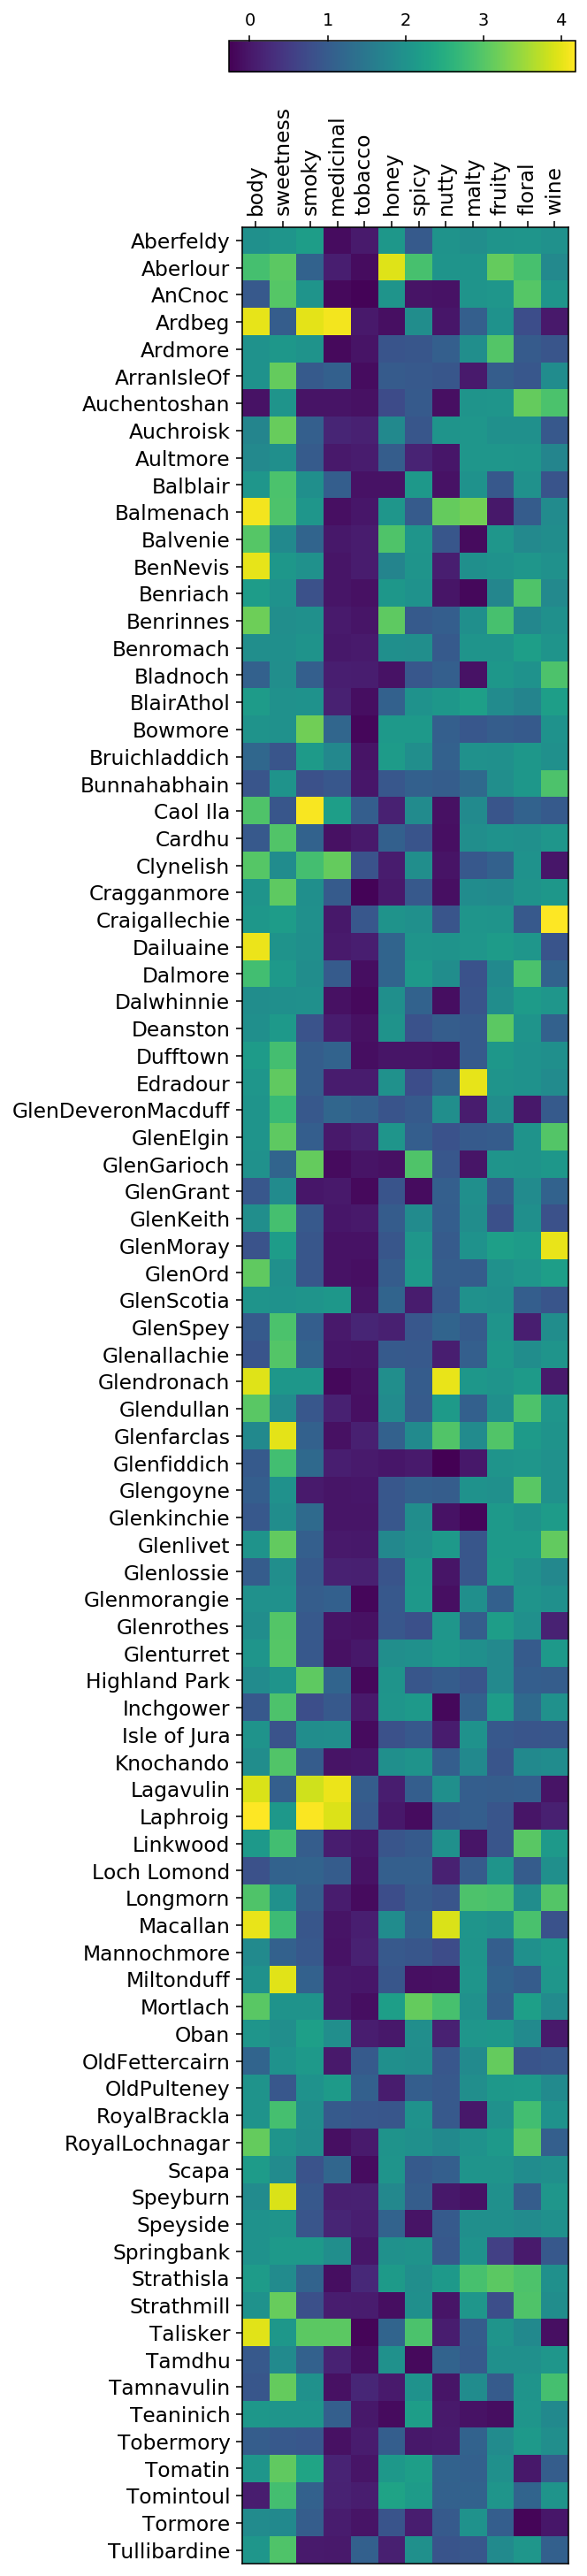

In [44]:
# show a plot of the whisky data
fig = plt.figure(figsize=(10,25))
ax = fig.add_subplot(1,1,1)

# image plot
img = ax.imshow(whisky)
ax.set_yticks(np.arange(len(distilleries)))
ax.set_yticklabels(distilleries, rotation="horizontal", fontsize=12)

# put the x axis at the top
ax.xaxis.tick_top()
ax.set_xticks(np.arange(len(columns)))
ax.set_xticklabels(columns, rotation="vertical", fontsize=12)

# some horrific colorbar hackery to put in the right place
# don't worry about this bit!
cbaxes = fig.add_axes([0.37, 0.93, 0.28, 0.01])  
fig.colorbar(img, orientation='horizontal',  cax=cbaxes, ticks=np.arange(5))
cbaxes.xaxis.tick_top()

### Available data
You now have these variables:

* `whisky` an  86x12 array of taste judgements, one row for each of the 86 distilleries. Each whisky has a rating 0-4 for each of the 12 flavour categories.
* `distilleries` is a list of 86 distillery names
* `columns` is a mapping of feature names to column indices.
* `locations` is an 86x2 matrix of positions of each distillery in [OS grid reference format](https://www.gridreferencefinder.com/) in the same order as `whisky`

For example:

In [45]:
print(whisky[distilleries.searchsorted('Glenfiddich'), 
             columns['smoky']])

1.2551637969677651


will tell you how "smoky" Glenfiddich was rated.

In [46]:
print(distilleries[8]) # distilleries is just a list of names

Aultmore


will tell you the 9th distillery in the dataset is `Aultmore`.

In [47]:
print(locations[distilleries.searchsorted('Glengoyne')])

[252810 682750]


will tell you where to find the Glengoyne distillery in UK OS grid units (you can almost see it out of the BO720 window if you look northwest). 

## A: Norms, interpolation and statistics
We will see some simple things we can do with this dataset. 


We can compute distances in **flavour space** between distilleries.

For example, we can compute the distance between the `Glenlivet` distillery and every other distillery *in terms of flavour, not physical distance*. The result will be a 1D array of 86 distances. 

Remember: distance between $\vec{x}$ and $\vec{y}$ is the norm of their difference: $\|\vec{x}-\vec{y}\|$

We can compute this for several different norms (e.g. $L_1, L_2$, and $L_\infty$)

We start by subtracting the flavour vector for `Glenlivet` from all the other flavour vectors in the `whisky` matrix.

We then use `np.linalg.norm` to compute the norm of every row vector in the resulting matrix. We set `axis=1` to ensure that norms are calculated "across columns", i.e. the norm of each row vector is calculated. We also specify which norm we want to calculate (`1` for $L_1$, `2` for $L_2$ or `np.inf` for $L_\infty$). The result is a 1D array of 86 distances in **flavour space**.

In [48]:
# Get the flavour vector for Glenlivet
glenlivet = whisky[distilleries.searchsorted("Glenlivet")]
print(glenlivet)

[2.01755609 3.10969454 1.07845611 0.02881886 0.01150817 1.80465997
 1.958898   2.12901747 0.91876381 2.13262264 2.14421457 3.11448683]


In [49]:
## Compute distances
# must use axis=1 to get the right result, otherwise the matrix norm will be used
# (the matrix norm is calculated across the whole matrix, rather than across each row vector!)
glenlivet_1 = np.linalg.norm(whisky - glenlivet, 1, axis=1)  # L_1
glenlivet_2 = np.linalg.norm(whisky - glenlivet, 2, axis=1)  # L_2
glenlivet_inf = np.linalg.norm(whisky - glenlivet, np.inf, axis=1)  # L_inf

### Visualising these distances
We can visualise these distances. This lets us see which distilleries produce whisky most similar to Glenlivet and which of them are most dissimilar. Note that we can use `argsort` to order a list of distances. Below, we plot a faceted graph, one facet for each norm, showing each distillery's flavour distance to `Glenlivet` as a rank bar plot (see Unit 3). The labels are a bit small, but the graphs are a useful summary of the distances in this abstract 12 dimensional space.

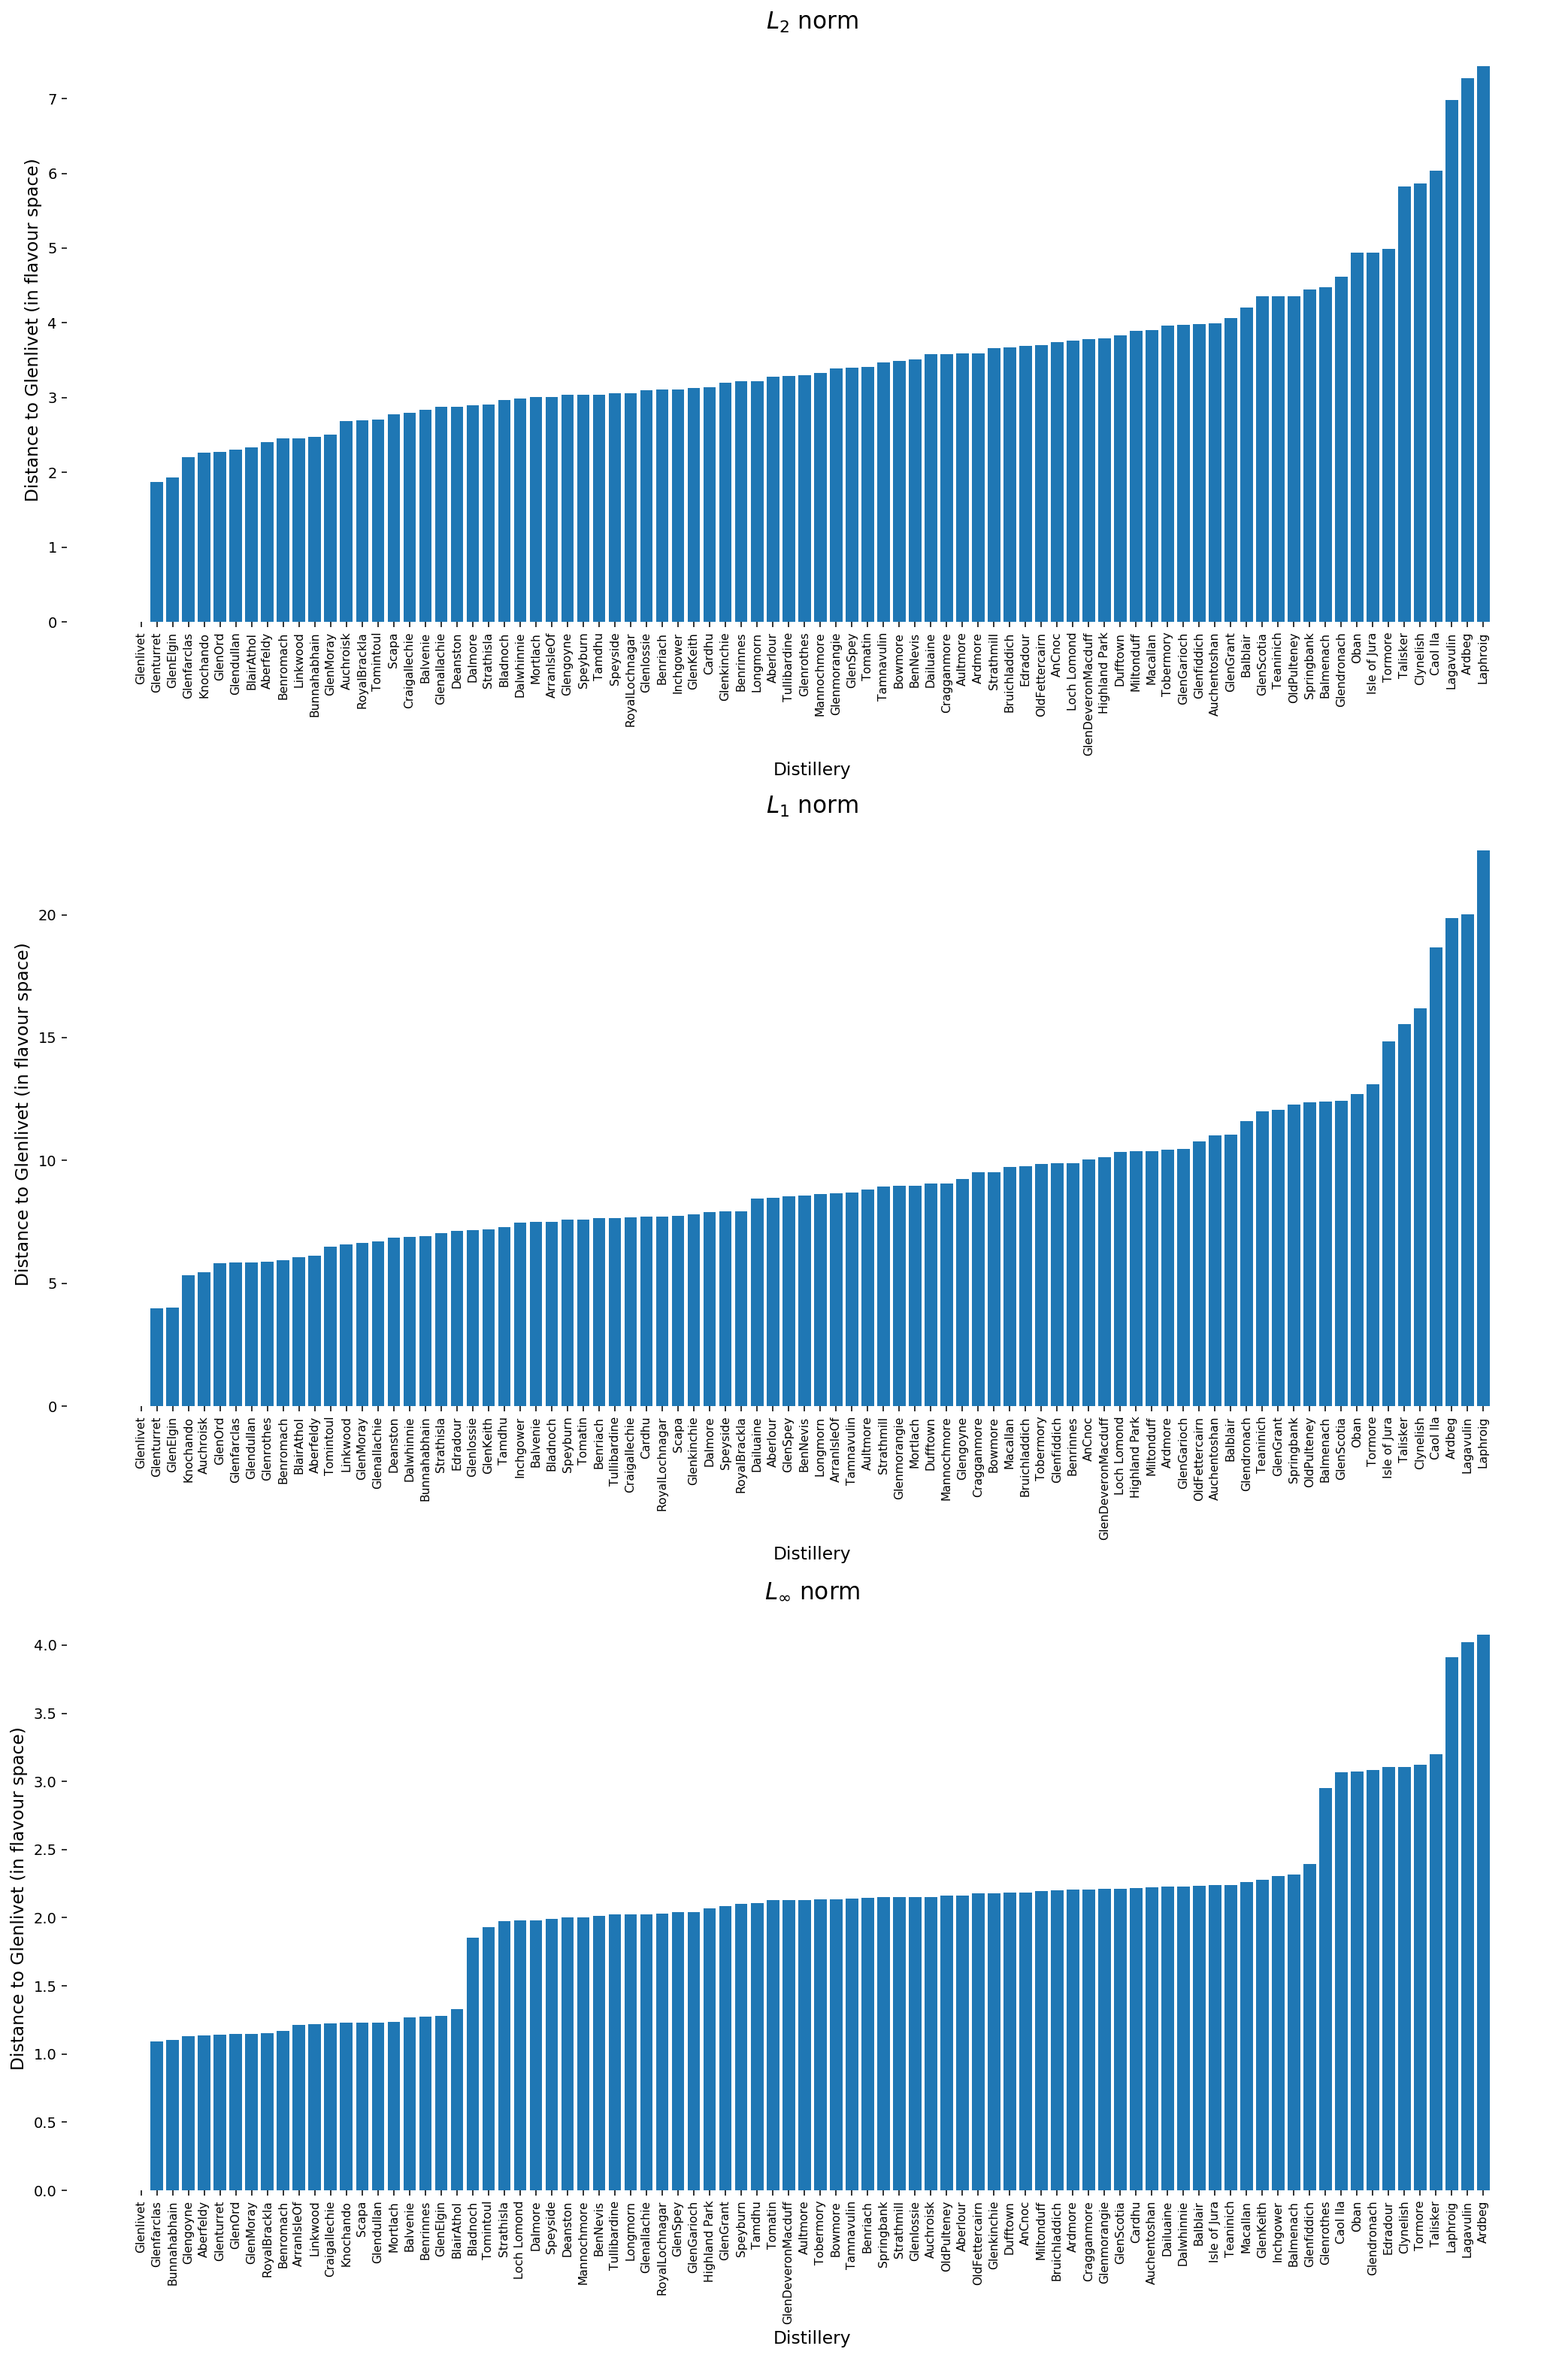

In [50]:
fig = plt.figure(figsize=(15, 22.5))

# you can use this utility function to
# help you get the xticklabels in order
def list_in_order(alist, order):
    """Given a list 'alist' and a list of indices 'order'
    returns the list in the order given by the indices"""
    return [alist[i] for i in order]


def rank_plot(distances):
    # find the ordering of the distances
    order = np.argsort(distances)
    # bar plot them
    ax.bar(np.arange(len(distances)), distances[order])
    ax.set_xlabel("Distillery", fontsize=12)
    ax.set_ylabel("Distance to Glenlivet (in flavour space)", fontsize=12)
    ax.set_xticks(np.arange(86))
    ax.set_frame_on(False)
    # make sure the same order is used for the labels!
    ax.set_xticklabels(
        list_in_order(distilleries, order), rotation="vertical", fontsize=8
    )


# make the plots
ax = fig.add_subplot(3, 1, 1)
ax.set_title("$L_2$ norm", fontsize=16)
rank_plot(glenlivet_2)
ax = fig.add_subplot(3, 1, 2)
ax.set_title("$L_1$ norm", fontsize=16)
rank_plot(glenlivet_1)
ax = fig.add_subplot(3, 1, 3)
ax.set_title("$L_\infty$ norm", fontsize=16)
rank_plot(glenlivet_inf)

# removes ugly overlapping
plt.tight_layout()

## Tasks

**Task A.1** 

Compute the $L_2$ norm of each distillery's flavour vector from the flavour vector corresponding to the distillery Glenfiddich, and store it in `glenfiddich_2`.

In [51]:
# YOUR CODE HERE
glenfiddich = whisky[distilleries.searchsorted("Glenfiddich")]
glenfiddich_2 = np.linalg.norm(whisky - glenfiddich, 2, axis=1)  # L_2

In [52]:
with tick.marks(4):        
    assert(check_hash(glenfiddich_2, ((86,), 14614.647247600076)))

**Task A.2** 
Which distillery is furthest from Glenfiddich's flavour profile in the $L_2$ norm? Store the distillery name in the variable in `unlike_glenfiddich`. Note: compute this - do not hardcode it.


In [53]:
# YOUR CODE HERE
unlike_glenfiddich = distilleries[np.argmax(glenfiddich_2)]

In [54]:
print("The distillery most unlike Glenfiddich (according to the L2 norm) is {distillery}.".
          format(distillery=unlike_glenfiddich))

The distillery most unlike Glenfiddich (according to the L2 norm) is Lagavulin.


In [55]:
with tick.marks(4):        
    assert(case_crc(unlike_glenfiddich)==3089990555)

3089990555


**Note** from now on, use the $L_2$ norm if you need to compute any norms.


### Vector arithmetic
A client says to you:
    
>    I'd like something a bit more "mellow" than Tormore, in the same way that Glenmorangie is more "mellow" than Bowmore.

Which whisky should you recommend? 

We can work this out:
* What does more "mellow" mean? We don't have a "mellow" column.
    * But we do have a reference point: Bowmore -> Glenmorangie is somehow "mellow"
    * This "direction" between these flavour vectors is *also* a vector
* How do we combine Tormore's flavour profile with "mellow"? We can compose vectors by addition.
* How do we find a distillery that represents this profile? We can compute lengths of vectors using a norm.

**Task A.3** Compute:
* `mellow` A vector representing what "mellow" is.
* `hypothetical_flavour` A vector representing a hypothetical flavour that would be a more mellow version of Tormore.
* `recommendation` the name of a specific distillery that we might recommend, as a string.

**Note: this question is not subjective, nor does it require any trial-and-error or knowledge about whisky. Answer it directly using vector arithmetic.**

In [56]:
# YOUR CODE HERE
bowmore = whisky[distilleries.searchsorted("Bowmore")]
glenmorangie = whisky[distilleries.searchsorted("Glenmorangie")]
tormore = whisky[distilleries.searchsorted("Tormore")]


mellow = glenmorangie - bowmore
hypothetical_flavour = tormore + mellow
recommendation = distilleries[np.argmin(np.linalg.norm(whisky - hypothetical_flavour, 2, axis=1))]

In [57]:
print("I would recommend {distillery} as a more 'mellow' version of Tormore.".format(distillery=recommendation))

I would recommend GlenGrant as a more 'mellow' version of Tormore.


In [58]:
with tick.marks(2):
    assert(check_hash(mellow, ((12,), -3.374787460507174)))

In [59]:
with tick.marks(2):
    assert(check_hash(hypothetical_flavour,((12,), 49.63291973521592)))

In [60]:
with tick.marks(1):
    assert(case_crc(recommendation)==3172520206)

3172520206


**Task A.4** Find the distillery that (as close as possible) makes a whisky twice as flavoursome across *all* flavours (in terms of the $L_2$ norm) as Glengarioch. Store the name in the variable `double_whisky`.

In [61]:
# YOUR CODE HERE
Glengariochx2 = whisky[distilleries.searchsorted("Glengarioch")] * 2

double_whisky = distilleries[np.argmin(np.linalg.norm(whisky - Glengariochx2, 2, axis=1))]

In [62]:
print("The whisky that is twice as flavoursome as Glengarioch is {distillery}.".format(distillery=double_whisky))

The whisky that is twice as flavoursome as Glengarioch is Strathisla.


In [63]:
with tick.marks(4):
    assert(case_crc(double_whisky)==1251638582)

1251638582


## Region flavours

We could say that the "representative" element of a collection of vectors was the one closest to the geometric centroid. This is given by the **mean vector** of a data set.

**Task A.5** Compute the mean vector of all of the flavour vectors. Use it to find the names of two distilleries:
* `most_representative` The distillery with the **most** representative flavour profile
* `least_representative` The distillery with the **least** representative flavour profile

In [64]:
# YOUR CODE HERE
mean = np.mean(whisky, axis=0)
most_representative = distilleries[np.argmin(np.linalg.norm(whisky - mean, 2, axis=1))]
least_representative = distilleries[np.argmax(np.linalg.norm(whisky - mean, 2, axis=1))]

In [65]:
print("The most representative whisky distillery is {most}, and the most unusual is {least}.".format(most=most_representative,
                                                                                           least=least_representative))

The most representative whisky distillery is Benromach, and the most unusual is Laphroig.


In [66]:
with tick.marks(4):
    assert(case_crc(most_representative)==125187962)
    assert(case_crc(least_representative)==2291391646)

125187962
2291391646



### A map
The code below will show a map of Scotland, with the distilleries in their correct positions. Different geographic regions have different characteristic flavour profiles.

One very distinctive region is the **island** region. This is a region bounded roughly by the box

    95000, 625000 -> 183000, 860000
    
in the same OS grid units used in the `locations` array. This is highlighted on the map below.


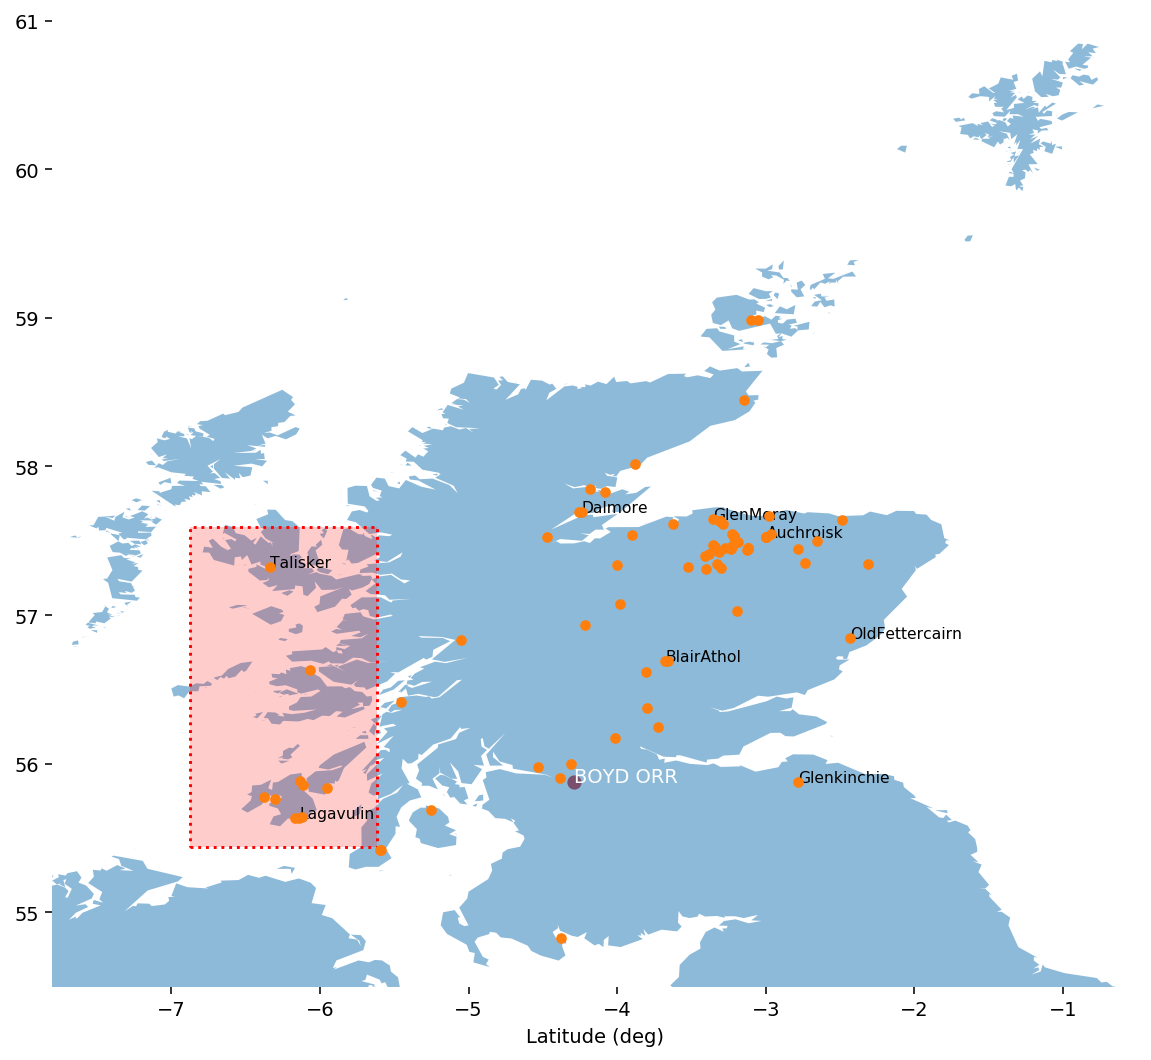

In [67]:
from whisky_map import draw_map, map_box

# draw each distillery label at the locations given.
ax = draw_map(locations, distilleries)

# show the island region
# draw a box in OS grid units
map_box(ax, 95000, 625000, 183000, 860000)

**Task A.6**
* Find all distilleries in island and use this to answer these questions:
* `island_flavour`: Compute the most typical whisky flavour profile for island whiskies. (i.e. a 12 element vector).
* `most_typical_island`: The specific name of the distillery from the islands that is most typical of that region;
* `most_atypical_island`: The specific name of the distillery from the islands that is most atypical of that region (i.e. furthest from the typical);
* `most_typical_non_island`: The specific name of the distillery from **outside** island that is most typical of that region;
* `most_like_island`: The specific name of the distillery from **outside** the islands that is most like a typical island distillery.

**Note:** do not do any of this by hand. Write code.
Hint: Boolean arrays.

In [68]:
# YOUR CODE HERE
#get boolean array using limits of the box
island_bool = (locations[:,0]<=183000) & (locations[:,1]<=860000) & (locations[:,0]>95000) & (locations[:,1]>625000)
#apply boolean to whisky attributes
islands_whis = whisky[island_bool]
#apply boolean to distilery locations
islands_dist = distilleries[island_bool]

#invert island boolean and find equivalents
non_islands_bool = np.logical_not(island_bool)
non_islands_whis = whisky[non_islands_bool]
non_islands_dist = distilleries[non_islands_bool]

#find mean of island attributes
island_flavour = np.mean(islands_whis, axis=0)
#find mean of non-island attributes
non_island_flavour = np.mean(non_islands_whis, axis=0)

#find minimum in list of norm between island mean and each island flavour
most_typical_island = islands_dist[np.argmin(np.linalg.norm(islands_whis - island_flavour, 2, axis=1))]
#find maximum in list of norm between island mean and each island flavour
most_atypical_island = islands_dist[np.argmax(np.linalg.norm(islands_whis - island_flavour, 2, axis=1))]

#find minimum in list of norm between typical non-island flavour and non-island flavours
most_typical_non_island = non_islands_dist[np.argmin(np.linalg.norm(non_islands_whis - non_island_flavour, 2, axis=1))]
##find minimum in list of norm between typical island flavour and non-island flavours
most_like_island = non_islands_dist[np.argmin(np.linalg.norm(non_islands_whis - island_flavour, 2, axis=1))]

In [69]:
with tick.marks(2):
    assert(check_hash(island_flavour, ((12,), 104.99538270254608)))

In [70]:
print("The most typical whisky of the island region is {most}.".format(most=most_typical_island))
print("The most atypical whisky of the island region is {most}.".format(most=most_atypical_island))
print("The most typical non-island whisky is {most}.".format(most=most_typical_non_island))
print("The non-island whisky most like island whiskies is {nonisland}.".format(nonisland=most_like_island))       

The most typical whisky of the island region is Isle of Jura.
The most atypical whisky of the island region is Tobermory.
The most typical non-island whisky is Benromach.
The non-island whisky most like island whiskies is GlenScotia.


In [71]:
with tick.marks(2):
    assert(case_crc(most_typical_island)==3459837550)

3459837550


In [72]:
with tick.marks(2):
    assert(case_crc(most_atypical_island)==999830981)

999830981


In [73]:
with tick.marks(2):    
    assert(case_crc(most_typical_non_island)==125187962)

125187962


In [74]:
with tick.marks(3):    
    assert(case_crc(most_like_island)==3296151715)

3296151715



# B: Eigendecompositions and whitening
This part uses ideas from Unit 5 of the course. You may wish to wait until after the Unit 5 lecture to attempt this section. 

You are welcome to attempt it in advance, but you will have to do your own research.



## Focusing data
<img src="imgs/drop.jpg" width="40%"> <br><br>*~[Image](https://flickr.com/photos/predi/236902022 "just a droplet, but upside down") by [Predi](https://flickr.com/people/predi) shared [CC BY-ND](https://creativecommons.org/licenses/by-nd/2.0/)*

This part will use  matrix decompositions to form abstract "lenses" that let us see data from different perspectives. This will let us pull out hidden structure and translate among representations.

## Demeaning
The dataset that we have is unnormalised. It is a set of ratings, 0-4, and many of the attributes rated are very correlated (e.g. `smoky` and `medicinal`). Many of the ratings are also on quite different scales, with `tobacco` being much less likely to be rated 4 than `floral`.

It is easier to work with normalised data. 

**Task B.1**
Compute:
* `mean_vector` the average flavour profile (you should have this from part A already)
* `demeaned_whisky` that has the mean flavour vector removed. 



In [75]:
# YOUR CODE HERE
mean_vector = np.mean(whisky, axis=0)
demeaned_whisky = whisky - mean_vector

Got hash (86, 12), -12996.960309576743 but expected (86, 12), -13044.960552493923


AssertionError: 

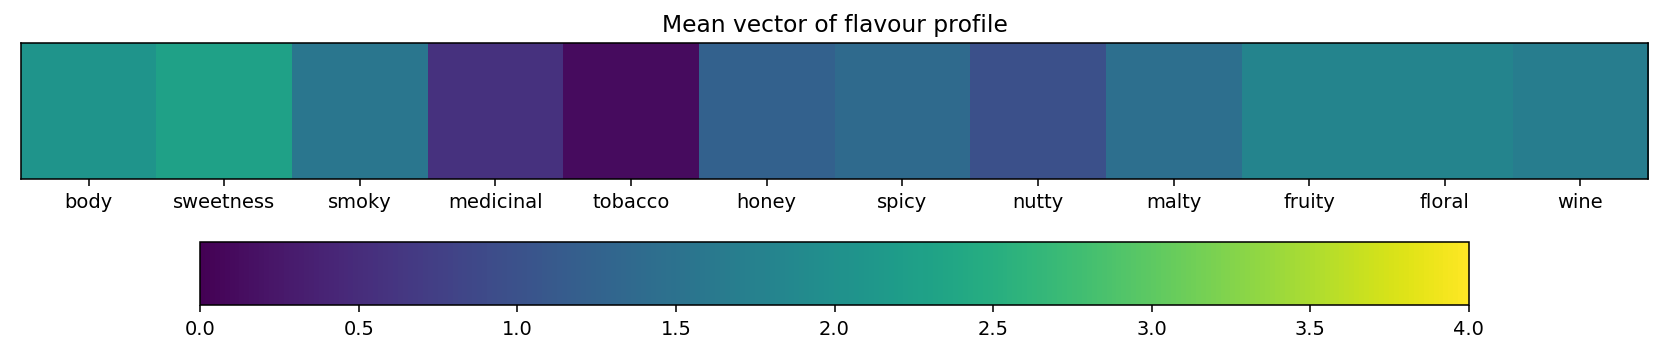

In [76]:
## Show the mean vector as an image strip
## Remember: this represents a point in space
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1,1,1)
img = ax.imshow(mean_vector[None,:], cmap='viridis', vmin=0, vmax=4)
ax.set_xticklabels(columns)
ax.set_xticks(np.arange(len(columns)))
ax.set_yticks([])
ax.set_title("Mean vector of flavour profile")
fig.colorbar(img, orientation='horizontal')

with tick.marks(2):
    assert(check_hash(demeaned_whisky, ((86, 12), -13044.960552493923)))

**Task B.2** Compute the **covariance matrix** of the *demeaned* data. Call this `whisky_cov`. 

The code below will show you this matrix as an image. **Note**: this should be a 12x12 matrix!

The covariance matrix tells us how different columns of the dataset are correlated (co-vary) with each other.

In [ ]:
# YOUR CODE HERE
whisky_cov = np.cov(demeaned_whisky, rowvar=False)

Got hash (12, 12), 617.9256928561159 but expected (12, 12), 611.8479842916136


AssertionError: 

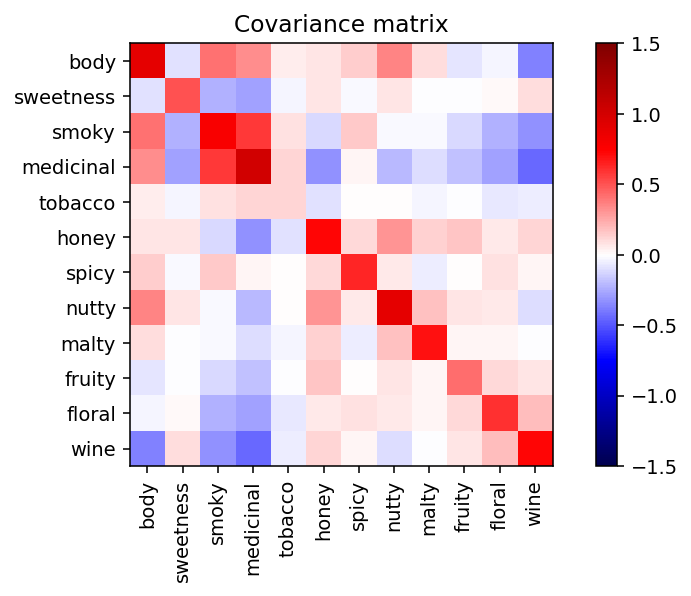

In [77]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
img = ax.imshow(whisky_cov, cmap='seismic', vmin=-1.5, vmax=1.5)
ax.set_xticks(np.arange(12))
ax.set_yticks(np.arange(12))
ax.set_yticklabels(columns)
ax.set_xticklabels(columns, rotation='vertical')
ax.set_title("Covariance matrix")
fig.colorbar(img)

with tick.marks(2):
    assert(check_hash(whisky_cov, ((12, 12), 611.8479842916136)))

From the image of the covariance matrix we can see several interesting things:
* having `body` is negatively correlated with the `wine` flavour
* being `smoky` is negatively correlated with having `sweetness`
* `nutty` is positively correlated with `body`

Although the raters have provided 12 different categories, it seems these are not fully independent of each other.

## Eigendecomposition of the covariance matrix

We would like to create some new flavour categories that are independent of each other (so that we don't have categories like smoky and medicinal that are given similar numbers by the tasters). We can do this by combining the existing flavour categories.

By looking at the covariance matrix, we can get an idea of which flavours are most correlated or most independent. Let's analyse this in more detail. Recall that the covariance matrix can be represented by an ellipse whose primary axes are the **eigenvectors** of the covariance matrix. The eigenvectors are a set of *independent* directions in which the dataset varies. 

These are the **principal components** of the dataset. We can compute these from the covariance matrix by taking the eigendecomposition. Each eigenvector of the covariance matrix is a **principal component** and its importance is given by the square root of the absolute value of its corresponding eigenvalue.

Note that a 12 x 12 matrix will be represented by a 12-dimensional ellipsoid, which we can't really visualise, but we can visualise the relative importance of the eigenvectors. 

**Task B.3**
* Compute all 12 of the eigenvectors of the covariance matrix, in order, with the *largest* corresponding eigenvalue first. Store these as a matrix of column vectors in `whisky_pc`. These eigenvectors are the principal components of the whisky data set.
* Compute the square root of every eigenvalue (we can think of these as lengths of the prinicipal components) and store them in `whisky_pc_len`. Make sure they are in descending order from largest to smallest.

In [78]:
# YOUR CODE HERE
#find the eigen value and vector from the covariance
eig_val ,eig_vec = np.linalg.eig(whisky_cov)

#find the boolean ordering of the eigan values
b00l_order = np.argsort(-np.abs(eig_val))

#use the order to sort the eigan values 
whisky_pc = eig_vec[:,b00l_order]

##use the order to sort the eigan values and find the square root
whisky_pc_len = np.sqrt(np.sort(eig_val)[::-1])

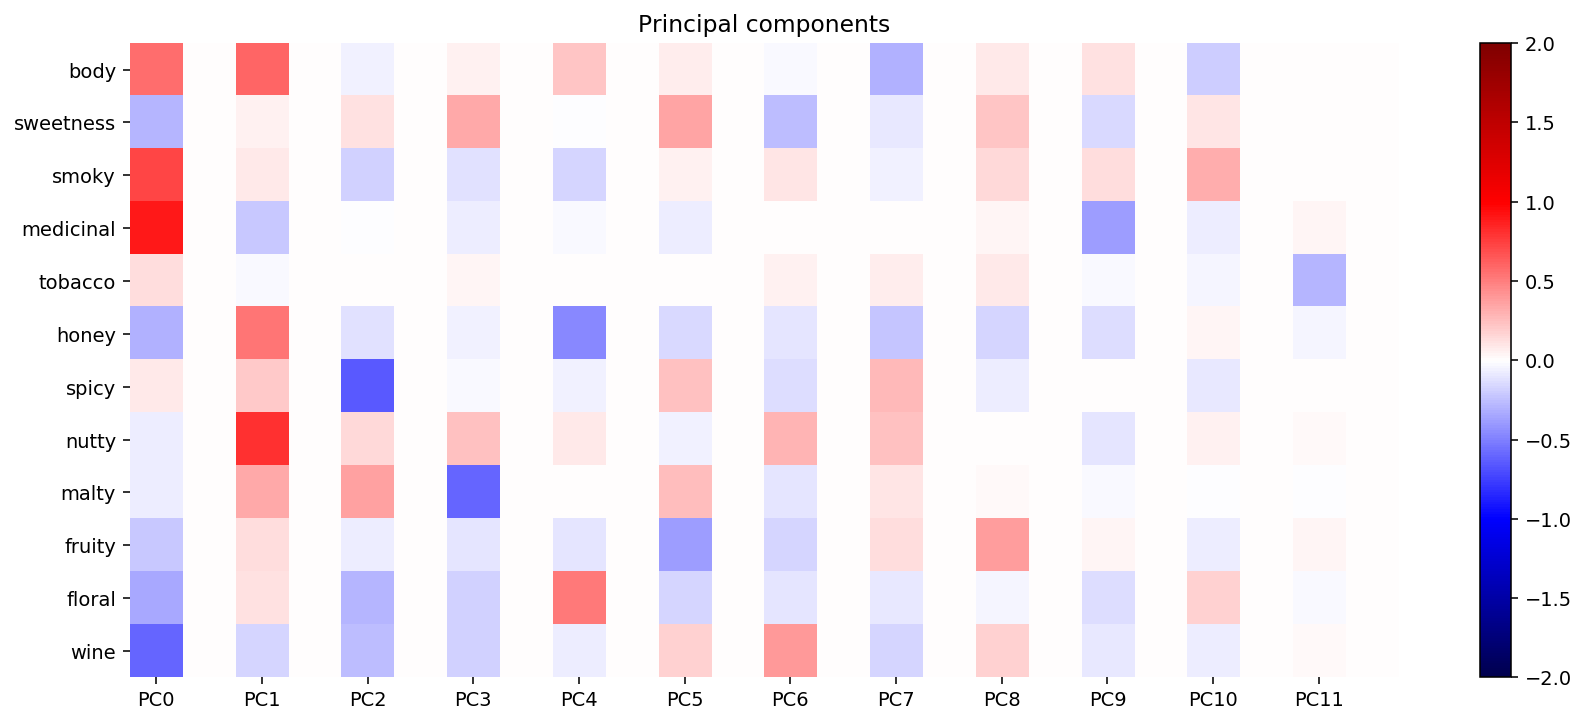

In [79]:
## We can show the principal components as an image
## Each row is a principal component and shows a vector
## which represents the direction of variation. The first
## vector represents the largest component.
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1,1,1)
# space out the principal components and scale them by the length of the components
img = ax.imshow(np.concatenate([(whisky_pc * whisky_pc_len), 
                                np.zeros_like(whisky_pc)], axis=0).T.reshape(24, -1).T, 
                cmap='seismic',         
                vmin=-2, vmax=2)

ax.set_yticks(np.arange(12))
ax.set_xticks(np.arange(0,24,2))
ax.set_xticklabels(["PC{i}".format(i=i) for i in np.arange(12)])
ax.set_yticklabels(columns)
ax.set_title("Principal components")
ax.set_frame_on(False)
fig.colorbar(img);

Text(0.5, 1.0, 'Component importances')

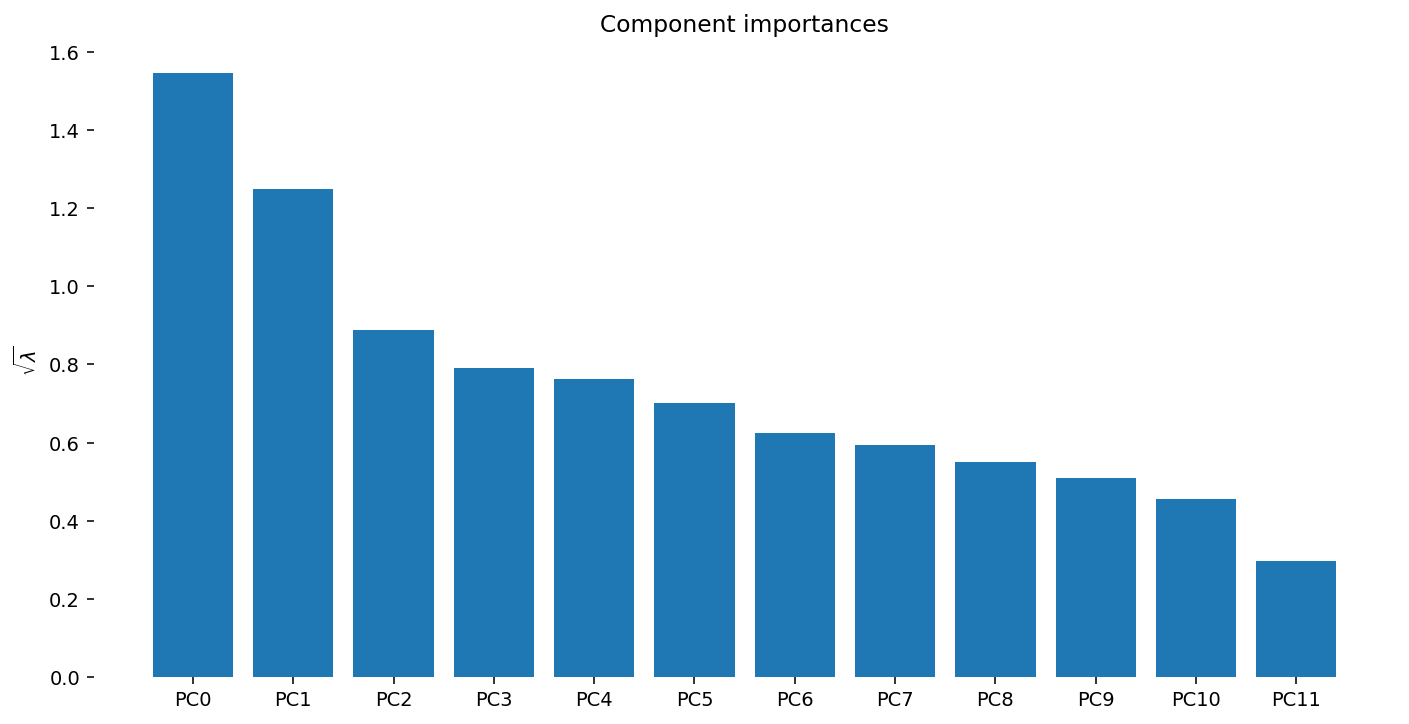

In [80]:
## Show the principal component lengths of this dataset
## This shows how much of the variation in the dataset
## is "explained" by the variation along the corresponding direction.
## In this case, we can see that the first and second components are the largest.
## PC1 is mainly a combination of "smoky", "medicinal" and "body",
## whereas PC2 is mainly a combination of "honey", "nutty", "malty" and "body".
## Further down the list, PC4 is strongly "floral"
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
ax.bar(np.arange(len(whisky_pc_len)), whisky_pc_len)
ax.set_xticks(np.arange(12))
ax.set_xticklabels(["PC{i}".format(i=i) for i in np.arange(12)])
ax.set_ylabel("$\sqrt{\lambda}$")
ax.set_frame_on(False)
ax.set_title("Component importances")

In [81]:
with tick.marks(4):
    assert(check_hash(whisky_pc, ((12, 12), -116.3856770814677)))
    assert(check_hash(whisky_pc_len, ((12,), 49.2805781587291)))

## Projecting onto the principal components

This is interesting, but quite hard to interpret. One very useful technique is to project data onto a small number of principal components, to visualise the data. This forms a simplified version of the data, where the use of principal components means we can map the directions in the data which are most important to our visual axes. For example, we might map the first two principal components to a 2D $x,y$ plot.

This is a key technique in exploratory data analysis: **principal component analysis**. All it involves is using the principal components to find a simplified mapping onto a lower-dimensional space.

We can compute a projection of a dataset onto an arbitrary set of vectors by forming a matrix product:
$$P = XV,$$

Where $P$ is an $N\times k$ matrix that is the result of the projection, $X$ is the $N \times D$ original data set and $V$ is an $D \times k$ matrix, each of whose *columns* is a vector that we want to project onto.

**Task B.4**
Use this information to project the distillery data onto the first two principal components, and store the result in `whisky_projected_2d`. If you do this correctly, the plot below should show a 2D mapping of whisky flavours, where more distant distilleries in the map represent more distinct flavour styles.




In [82]:
# YOUR CODE HERE

#multiply whisky with the first 2 columns of the sorted covariance matrix
whisky_projected_2d = whisky @ whisky_pc[:,0:2]

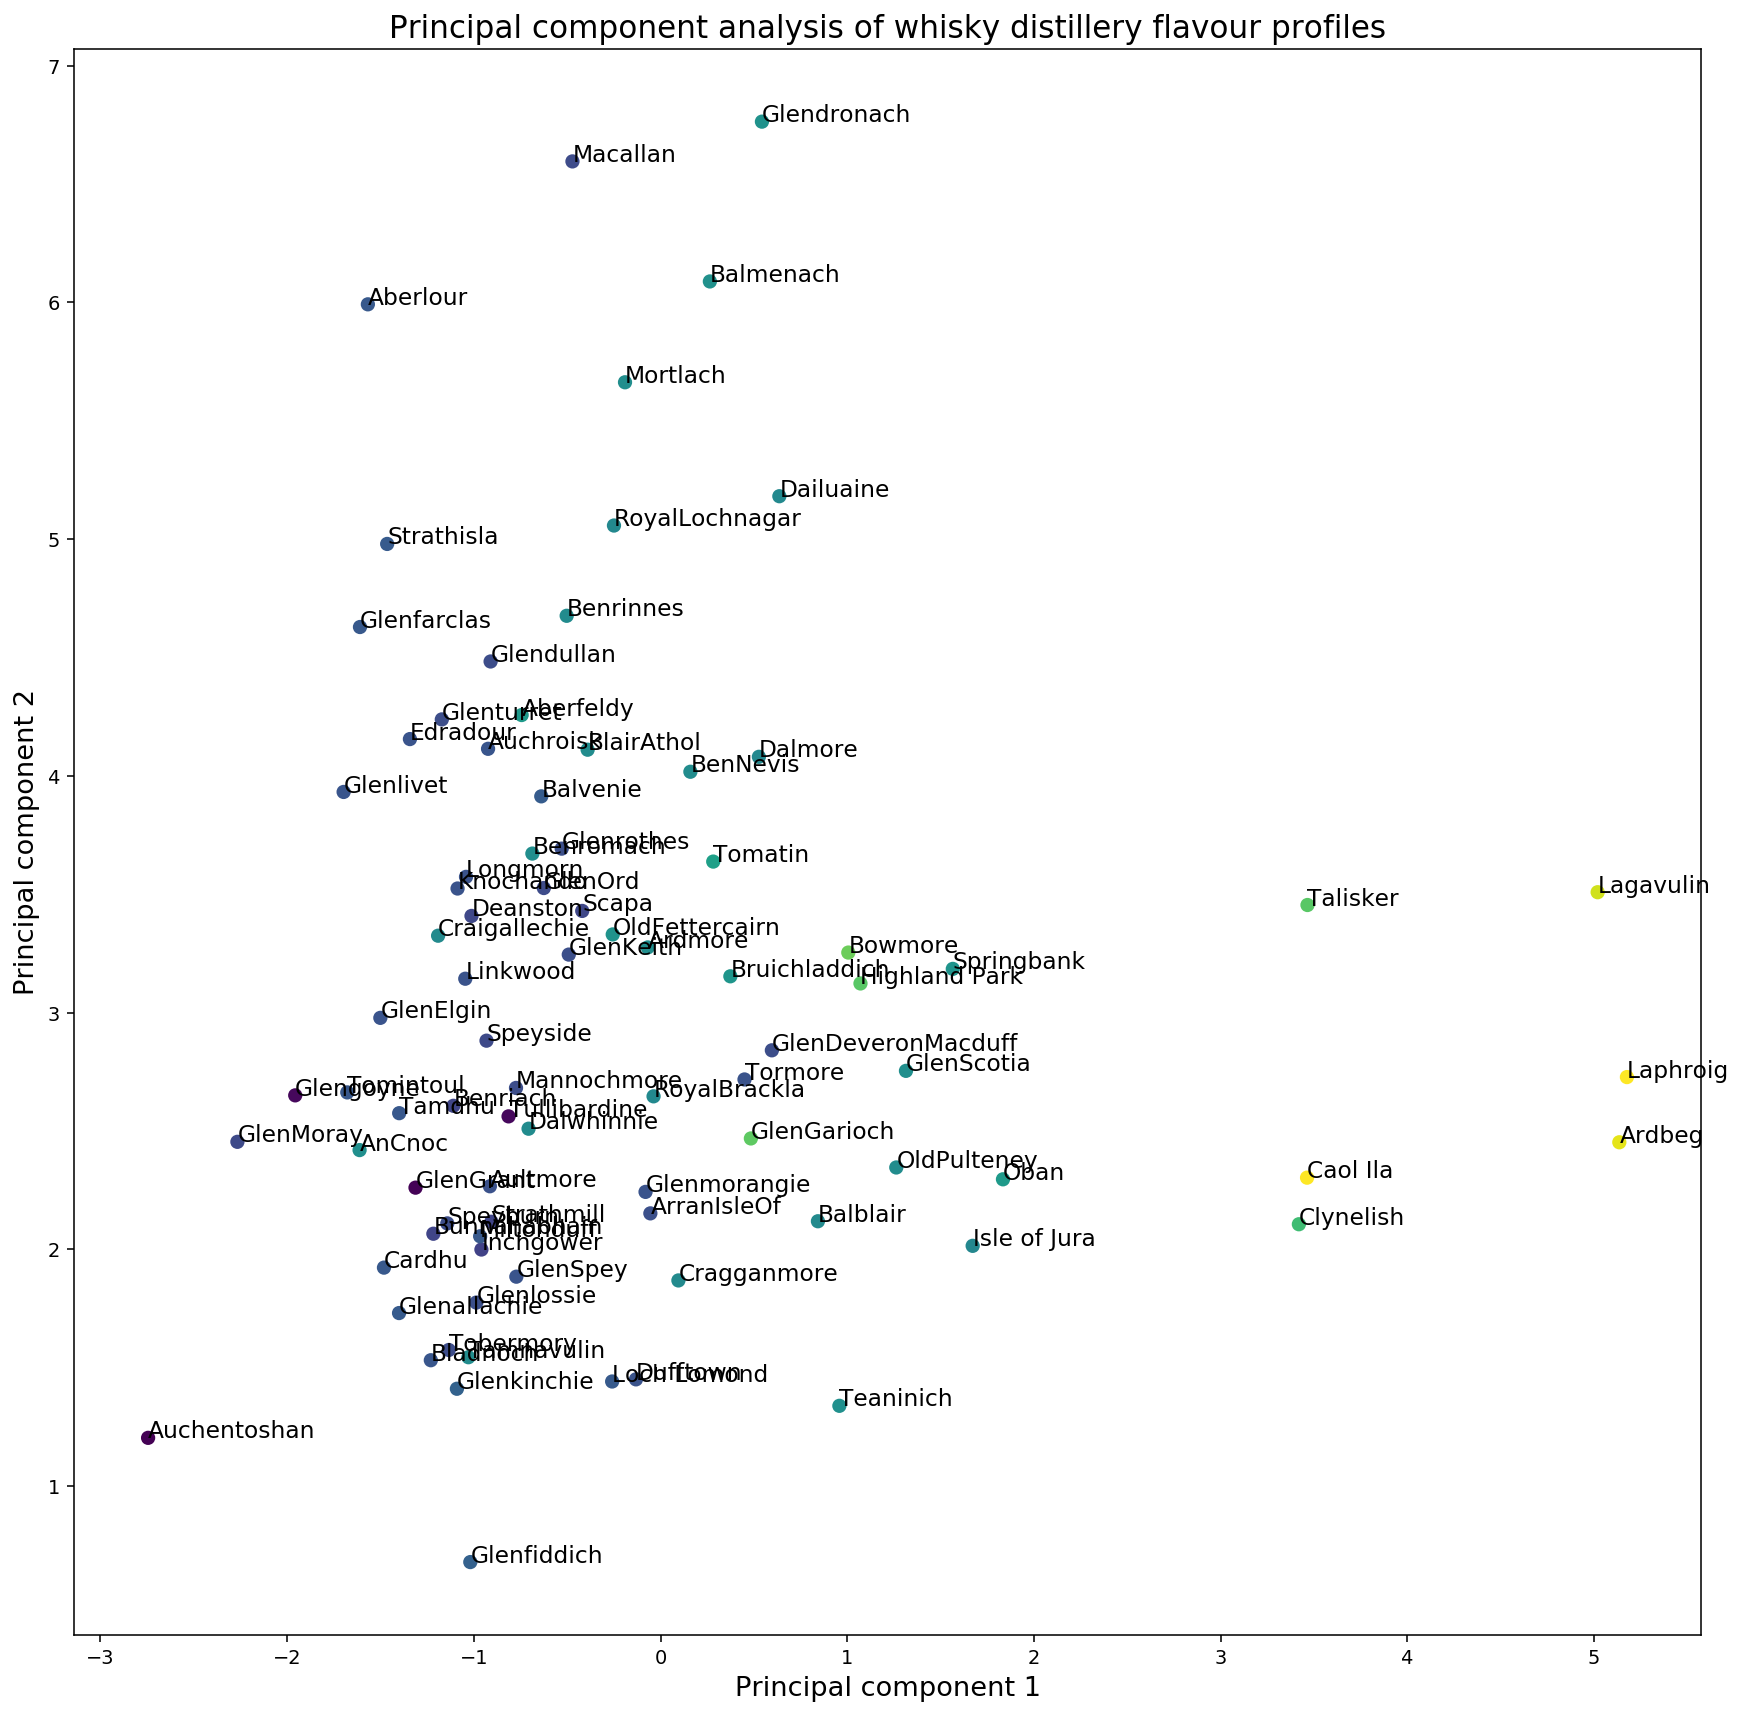

In [83]:
## Show the whisky distilleries laid out
## on the two first principal components,
## colouring the points according to the level of smokiness 
## (just to see that similar whiskies are indeed clustered together)
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1,1,1)
#ax.set_frame_on(False)
ax.set_xlabel("Principal component 1", fontsize=14)
ax.set_ylabel("Principal component 2", fontsize=14)
ax.set_title("Principal component analysis of whisky distillery flavour profiles", fontsize=16)
ax.scatter(whisky_projected_2d[:,0], whisky_projected_2d[:,1], c=whisky[:,columns['smoky']], s=40)
#ax.scatter(whisky_projected_2d[:,0], whisky_projected_2d[:,1], c=whisky[:,columns['nutty']], s=40)
for i,name in enumerate(distilleries):
    ax.text(whisky_projected_2d[i,0], whisky_projected_2d[i,1], name, fontdict={'size':12})

In [84]:
with tick.marks(4):
    assert(check_hash(whisky_projected_2d, ((86, 2), 21159.91633246404)))


We can normalise this data further. Whiten the dataset so that it has zero mean and unit covariance. This transforms our dataset so that it is centered on the origin (demeaning) and "spherical" (whitenening with covariance matrix). This is particularly useful if we are going to try and map from data in one vector space to another; having the data in standard scaling, with no offset and no correlation among dimensions makes the data easier to work with.

**Task B.5**
Use the SVD to compute the inverse square root of the covariance matrix `whisky_cov`. Multiply the demeaned whisky matrix by this to produce `whitened_whisky`. This represents the data with the mean removed and all correlations eliminated.



In [85]:
# YOUR CODE HERE

n = -0.5

u, sigma, vt = np.linalg.svd(whisky_cov)
sigma_n= np.diag(sigma**n)
inverse_cov = u @ sigma_n @ vt

whitened_whisky = demeaned_whisky @ inverse_cov

Got hash (86, 12), -13840.852324929745 but expected (86, 12), -13904.23411235108


AssertionError: 

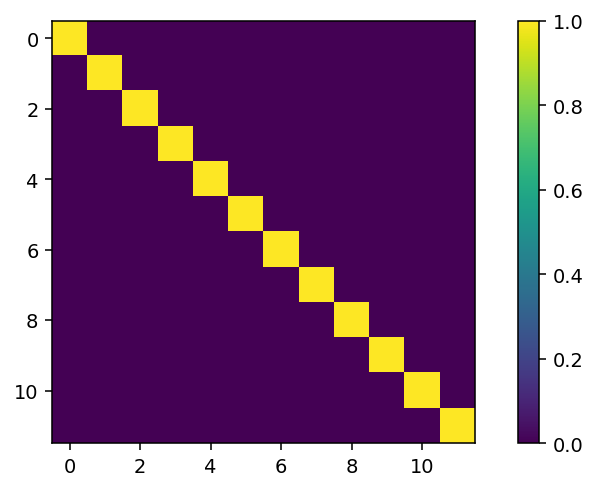

In [86]:
# This plot of the covariance matrix should now be perfectly diagonal
plt.imshow(np.cov(whitened_whisky.T), vmin=0, vmax=1, cmap='viridis')
plt.colorbar()

with tick.marks(4):
    assert(check_hash(whitened_whisky, ((86, 12), -13904.23411235108)))

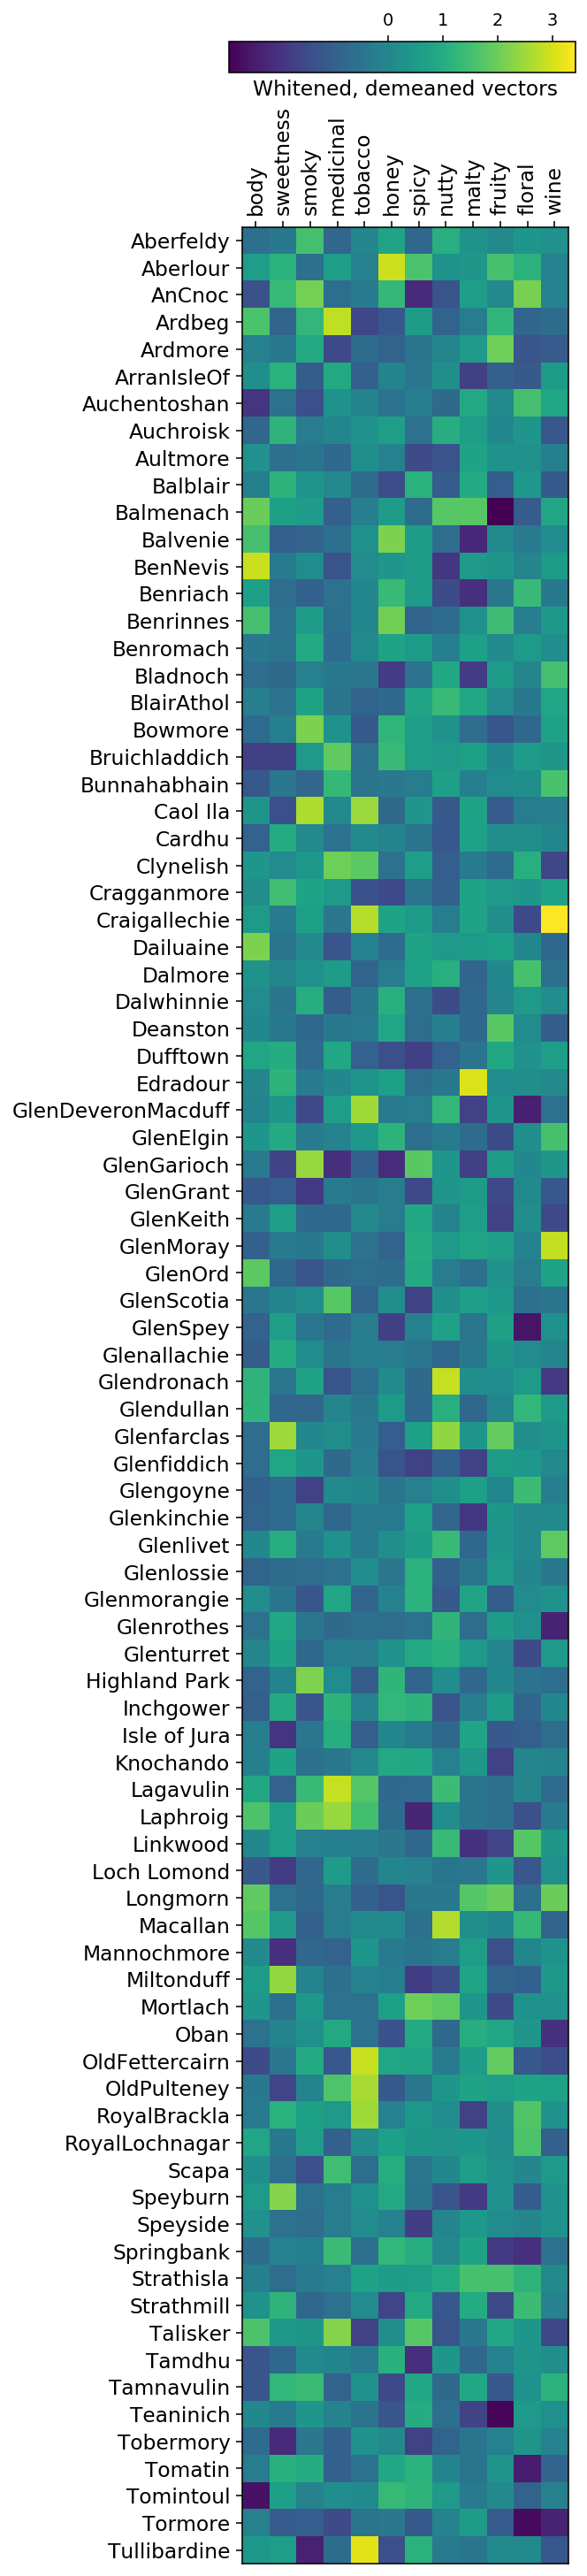

In [87]:
# show a plot of the whisky data
fig = plt.figure(figsize=(10,25))
ax = fig.add_subplot(1,1,1)
ax.set_title("Whitened, demeaned vectors")
# image plot
img = ax.imshow(whitened_whisky)
ax.set_yticks(np.arange(len(distilleries)))
ax.set_yticklabels(distilleries, rotation="horizontal", fontsize=12)

# put the x axis at the top
ax.xaxis.tick_top()
ax.set_xticks(np.arange(len(columns)))
ax.set_xticklabels(columns, rotation="vertical", fontsize=12)

# some horrific colorbar hackery to put in the right place
# don't worry about this bit!
cbaxes = fig.add_axes([0.37, 0.93, 0.28, 0.01])  
fig.colorbar(img, orientation='horizontal',  cax=cbaxes, ticks=np.arange(5))
cbaxes.xaxis.tick_top()

### Visualising in normalised space
Now that we have the data normalised, we could also define a more sensible way to compare vectors in a high-dimensional space. The $L_2$ norm has significant problems in very high-dimensional spaces. A more sensible way to compare high-dimensional vectors is to look at the *angle* between them.

**Task B.6**
Define a function `cosine(a, b)` that computes the cosine of the angle between two vectors `a` and `b`. 

N.B. This should be a value between -1 and 1.

In [88]:
# YOUR CODE HERE
def cosine(a, b):
    dot_p = np.dot(a,b)
    
    mag_a = np.linalg.norm(a)
    mag_b = np.linalg.norm(b)
    
    cos = dot_p/(mag_a*mag_b)
    
    return(cos)

In [89]:
angles = np.array([cosine(whitened_whisky[i,:], whitened_whisky[j,:]) for i in range(len(whisky)) for j in range(len(whisky))])

with tick.marks(2):
    assert(check_hash(angles, ((7396,), 25457.146694199713)))

## A 3D visualisation
We can use this to show a different layout of whiskies; this time in terms of relative angles to two reference distillieries, in the whitened space. This has the advantage that all distances are normalised to the range [-1,1], and we have a good spread of points in the space. The plot below shows the angle with respect to 3 distilleries, as a 3D plot. Tou can compare with the plot using the unwhitened data to see the effect that normalisation has had, if you wish.

This is also an example of why visualising data in 3D is usually a bad idea.

<IPython.core.display.Javascript object>


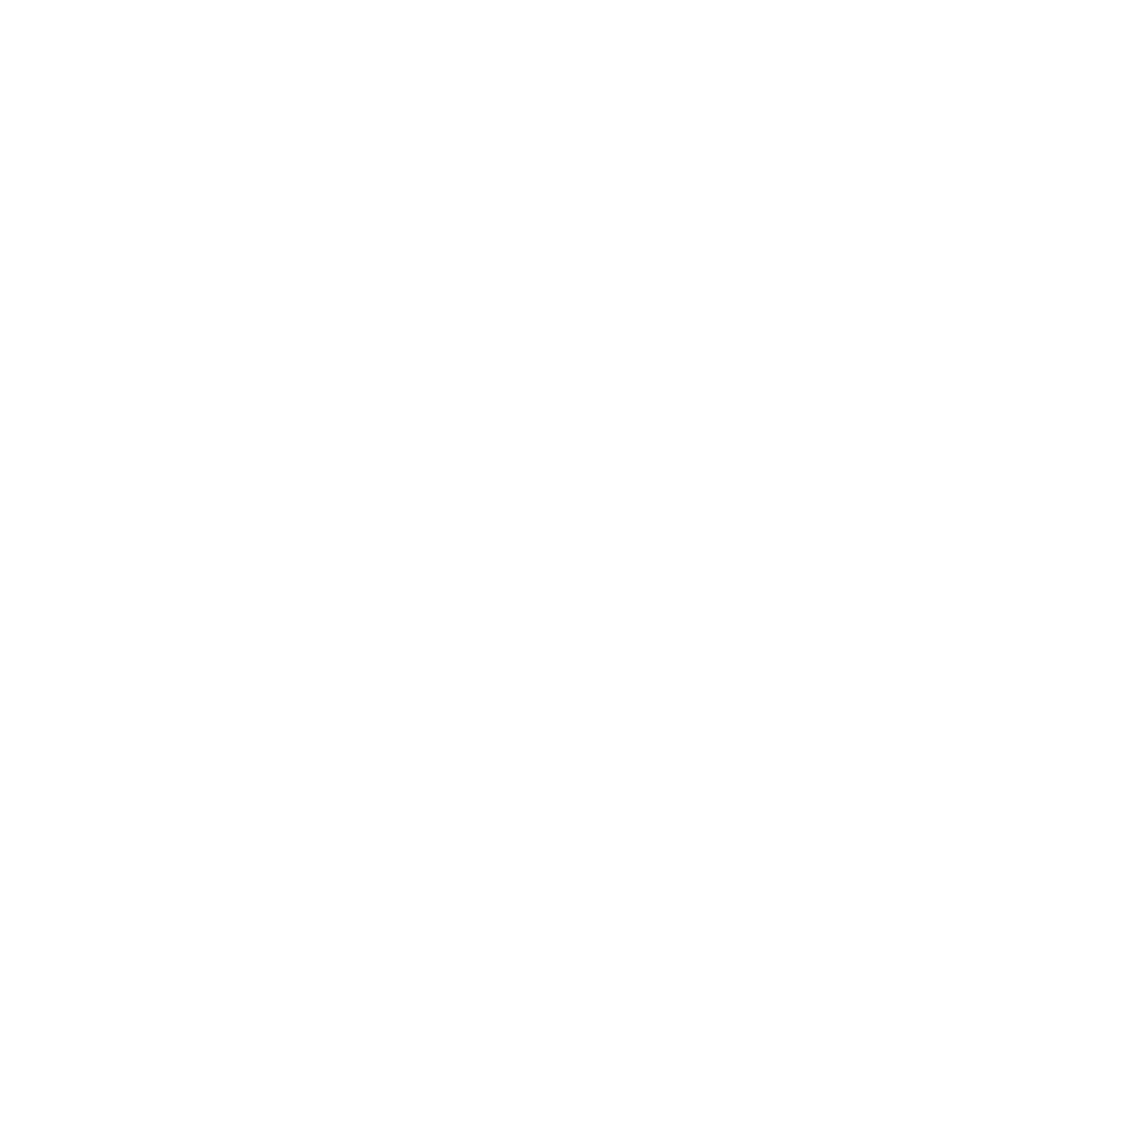

Text(0.5, 0.92, 'Normalised flavour angles between whisky distilleries')

<IPython.core.display.Javascript object>


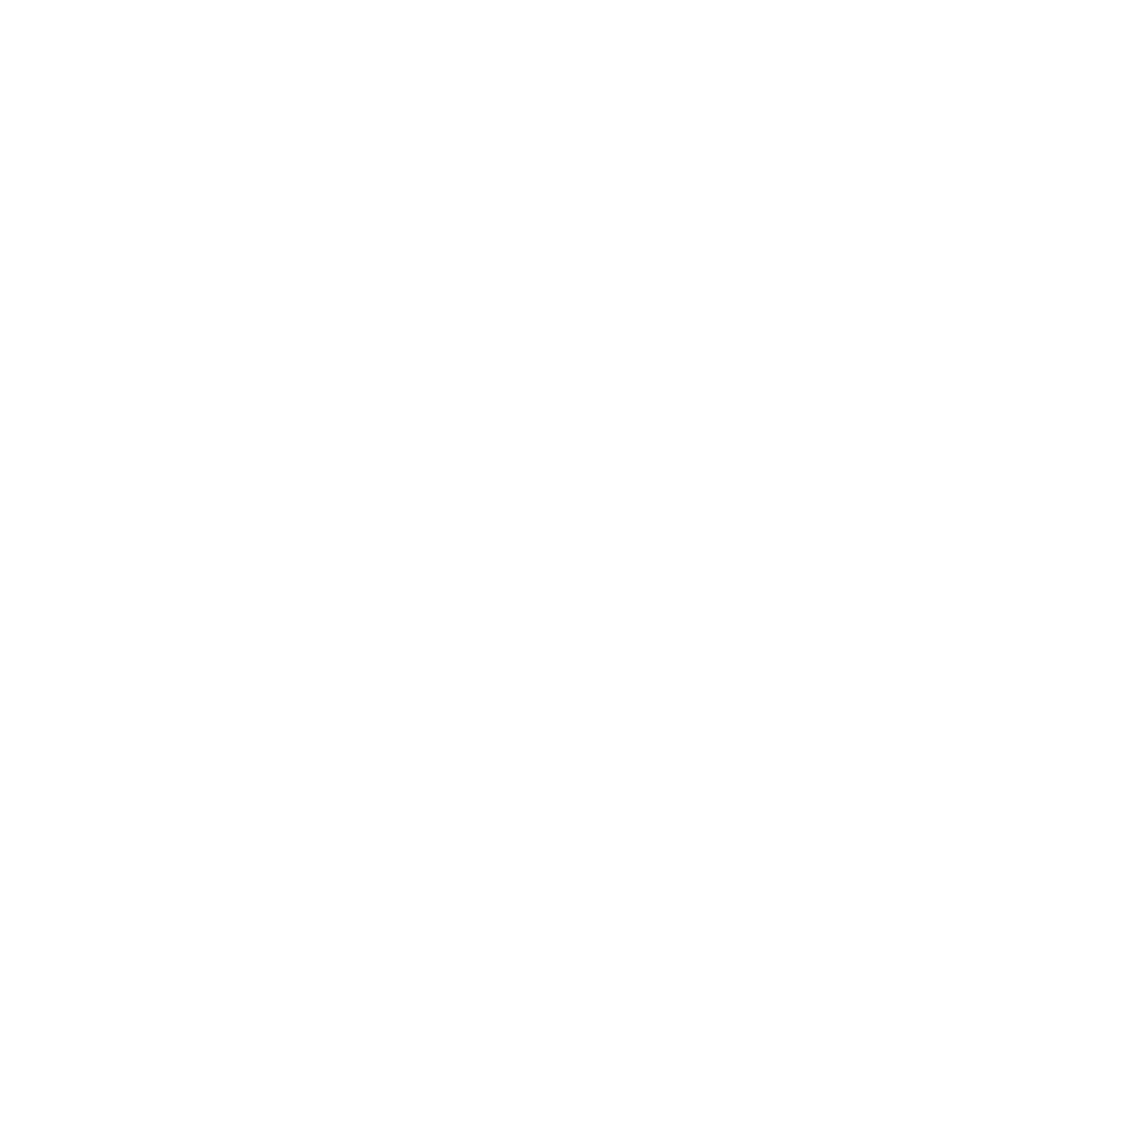

In [90]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
import matplotlib.pyplot as plt
%matplotlib notebook

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1, projection='3d')

## Modify these to plot the flavours on different axes
ref_a = 'Glengoyne'
ref_b = 'Laphroig'
ref_c = 'Glenlivet'

## get the respective flavour vectors
reference_a = whitened_whisky[distilleries.searchsorted(ref_a)]
reference_b = whitened_whisky[distilleries.searchsorted(ref_b)]
reference_c = whitened_whisky[distilleries.searchsorted(ref_c)]

for name, flavour in zip(distilleries, whitened_whisky):
    ## compute angles to the references
    angle_a = cosine(reference_a, flavour)
    angle_b = cosine(reference_b, flavour)
    angle_c = cosine(reference_c, flavour)

    ax.scatter(angle_a, angle_b, angle_c, color='c', s=5)
    ax.text(angle_a, angle_b, angle_c, name, fontdict={"size":4}, alpha=0.5)
    
## fix up the plot
ax.set_xlabel("Angle with respect to {ref_a}".format(ref_a=ref_a))
ax.set_ylabel("Angle with respect to {ref_b}".format(ref_b=ref_b))
ax.set_zlabel("Angle with respect to {ref_c}".format(ref_c=ref_c))
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_zlim(-1.1, 1.1)
ax.set_title("Normalised flavour angles between whisky distilleries")

In [91]:
tick.summarise_marks()

-----

# Submission instructions

## Before submission

* Make sure you fill in any place that says `YOUR CODE HERE` or `"YOUR ANSWER HERE"`.
* SAVE THE NOTEBOOK



<div class="alert alert-block alert-danger">
    
### Formatting the submission
* **WARNING**: If you do not submit the correct file, you will not get any marks.
* Submit this file **only** on Moodle. It will be named `<xxx>.ipynb`.

</div>


## Penalties (only for assessed labs)
<font color="red">
    
**Malformatted submissions**
</font>
These assignments are processed with an automatic tool; failure to follow instructions *precisely* will lead to you automatically losing two bands in grade regardless of whether the work is correct (not to mention a long delay in getting your work back). **If you submit a file without your work in it, it will be marked and you will get 0 marks.**

<font color="red">**Late submission**</font>
Be aware that there is a two band penalty for every *day* of late submission, starting the moment of the deadline.

<font color="red">
    
**Plagiarism**
</font> Any form of plagiarism will be subject to the Plagiarism Policy. The penalties are severe.